In [1]:
import os
import sys
sys.path.append('./src')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt
import numpy as np

/home/haselab/anaconda3/envs/anomar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
from torch.utils.data import DataLoader
import torch

category = "juice_bottle"

dataset = build_dataset(
    dataset_name='mvtec_loco',
    data_root = "data/mvtec_loco",
    train=False,
    img_size=224,
    transform_type="default",
    category = f"{category}",
    anom_only = True
)
print(len(dataset))
bs = 4
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

batch = list(dataloader)[-2]
samples = batch["samples"].to("cuda")
samples.shape

219


torch.Size([4, 3, 224, 224])

In [ ]:
config_path = "./results/ad_dit_d8w768/pill/config.yaml"
ckpt_path = "./results/ad_dit_d8w768/pill/model_latest.pth"


with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    
vae = create_vae(**config["vae"])
vae = vae.cuda()
vae.eval()
vae_embed_dim = config['vae']['embed_dim']
vae_stride = config['vae']['stride']
img_size = config['data']['img_size']
patch_size = config['diffusion']['patch_size']
diff_in_sh = (vae_embed_dim, img_size // vae_stride, img_size // vae_stride)

# For now
denoiser_ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=True)
denoiser_ckpt['cls_embed.weight'] = denoiser_ckpt['clas_embed.weight']

denoiser = get_denoiser(**config['diffusion'], input_shape=diff_in_sh)
denoiser.load_state_dict(denoiser_ckpt, strict=False)
denoiser.cuda()
denoiser.eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from ./weights/vae/kl16.ckpt


Denoiser(
  (cls_embed): Embedding(15, 768)
  (net): DiT(
    (x_embedder): PatchEmbed(
      (proj): Conv2d(16, 768, kernel_size=(2, 2), stride=(2, 2))
      (norm): Identity()
    )
    (x_embedder_linear): Linear(in_features=16, out_features=768, bias=True)
    (z_embedder): ConditionEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=16, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (y_embedder): LabelEmbedder(
      (embedding_table): Embedding(15, 768)
    )
    (blocks): ModuleList(
      (0-7): 8 x DiTBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_featu

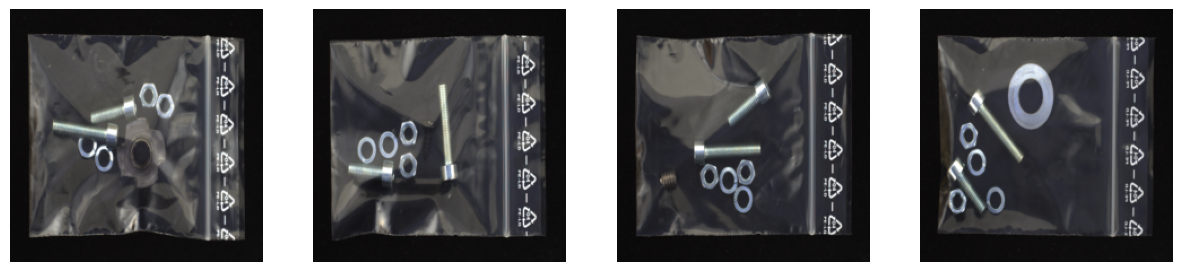

In [60]:
def denormalize(x):
    # [-1, 1] => [0, 1]
    return x / 2 + 0.5

anomaly_images = batch["samples"].permute(0, 2, 3, 1).cpu().numpy()
anomaly_samples = denormalize(anomaly_images)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(anomaly_samples[i])
    axs[i].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5082438..1.4096272].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94918203..1.6204336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4914596..2.246303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7785766..2.720041].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48001933..1.3353115].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8846879..1.7672751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.593245

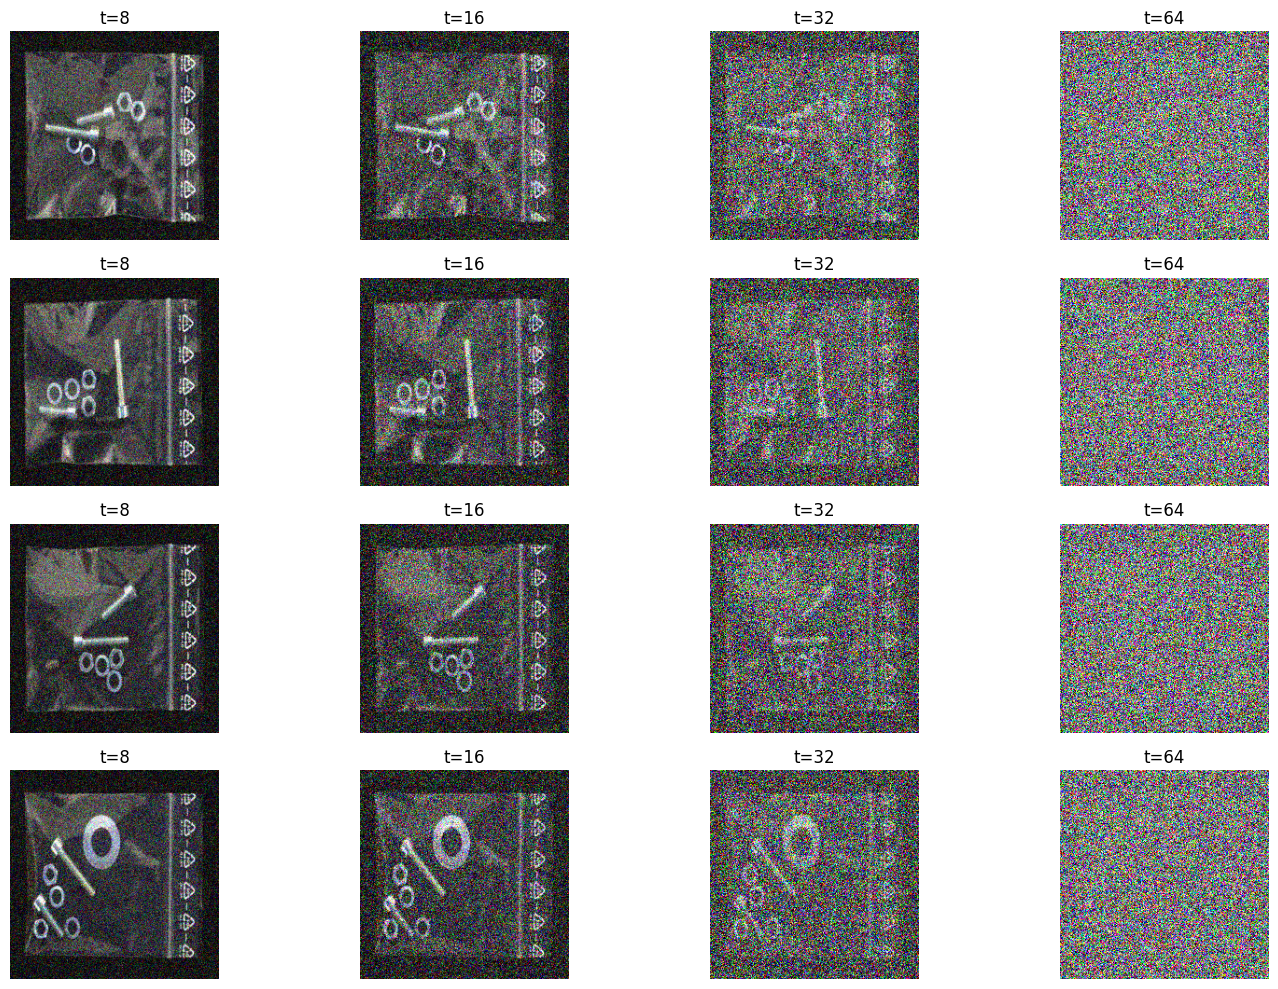

In [61]:
# add noise
x_t_list = []
t_range = [8, 16, 32, 64]
for t in t_range:
    x_t = denoiser.q_sample(samples, torch.tensor([t] * bs).cuda())
    x_t_list.append(x_t)

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(denormalize(x_t_list[j][i].permute(1, 2, 0).cpu().numpy()))
        ax[i, j].axis("off")
        ax[i, j].set_title(f"t={t_range[j]}")
        
plt.tight_layout()
plt.show()

### Note: The denoised images show the loss of original information. But we acutually use the denoised vae latent. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.012961358..1.0727057].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018949032..1.1281028].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018813908..1.0791967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.013778567..1.0124278].


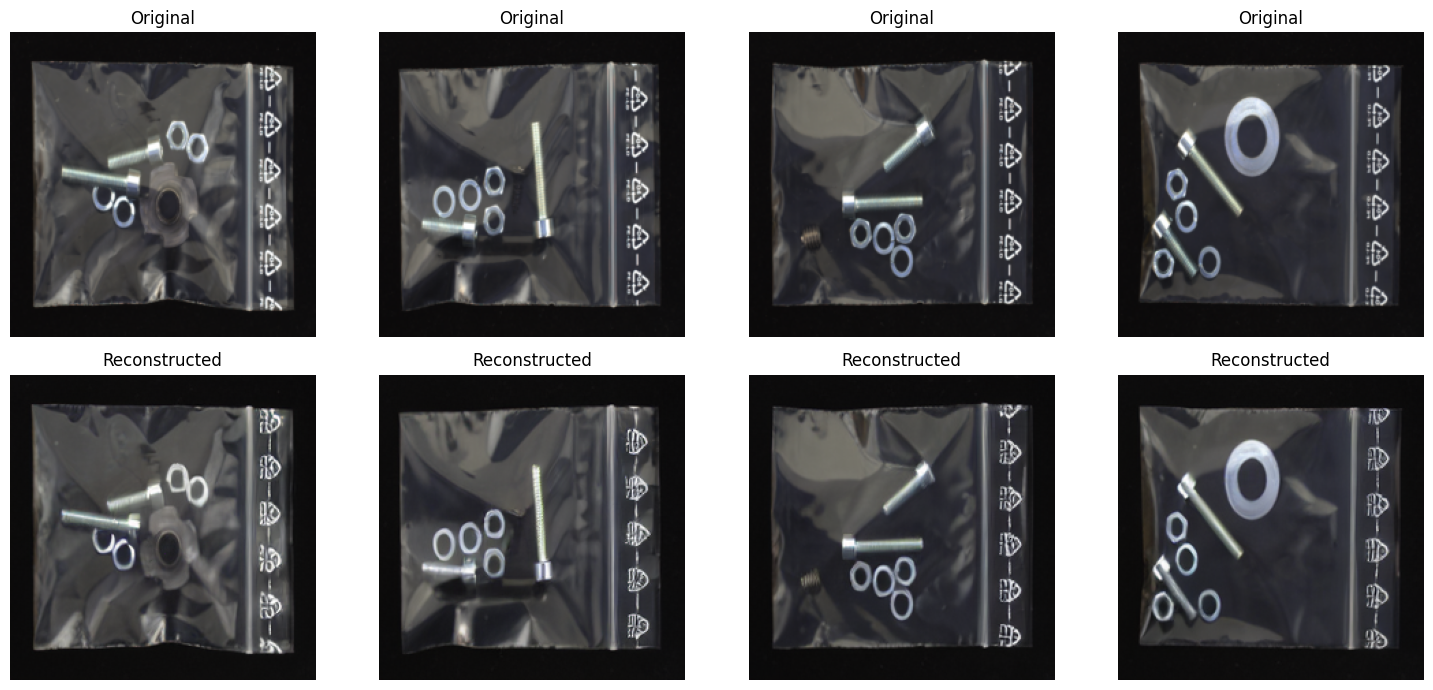

In [62]:
# Visualize the vae reconstruction

with torch.no_grad():
    z = vae.encode(samples).sample().mul_(0.2325)
    z_recon = vae.decode(z / 0.2325).cpu()

recon_samples = denormalize(z_recon.permute(0, 2, 3, 1).numpy())

fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i in range(4):
    axs[0, i].imshow(anomaly_samples[i])
    axs[0, i].axis("off")
    axs[0, i].set_title("Original")
    
    axs[1, i].imshow(recon_samples[i])
    axs[1, i].axis("off")
    axs[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015874147..1.1399173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018663287..1.1507425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10765743..1.1369534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12060183..1.1271707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014440298..1.0788953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010177404..1.1572455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

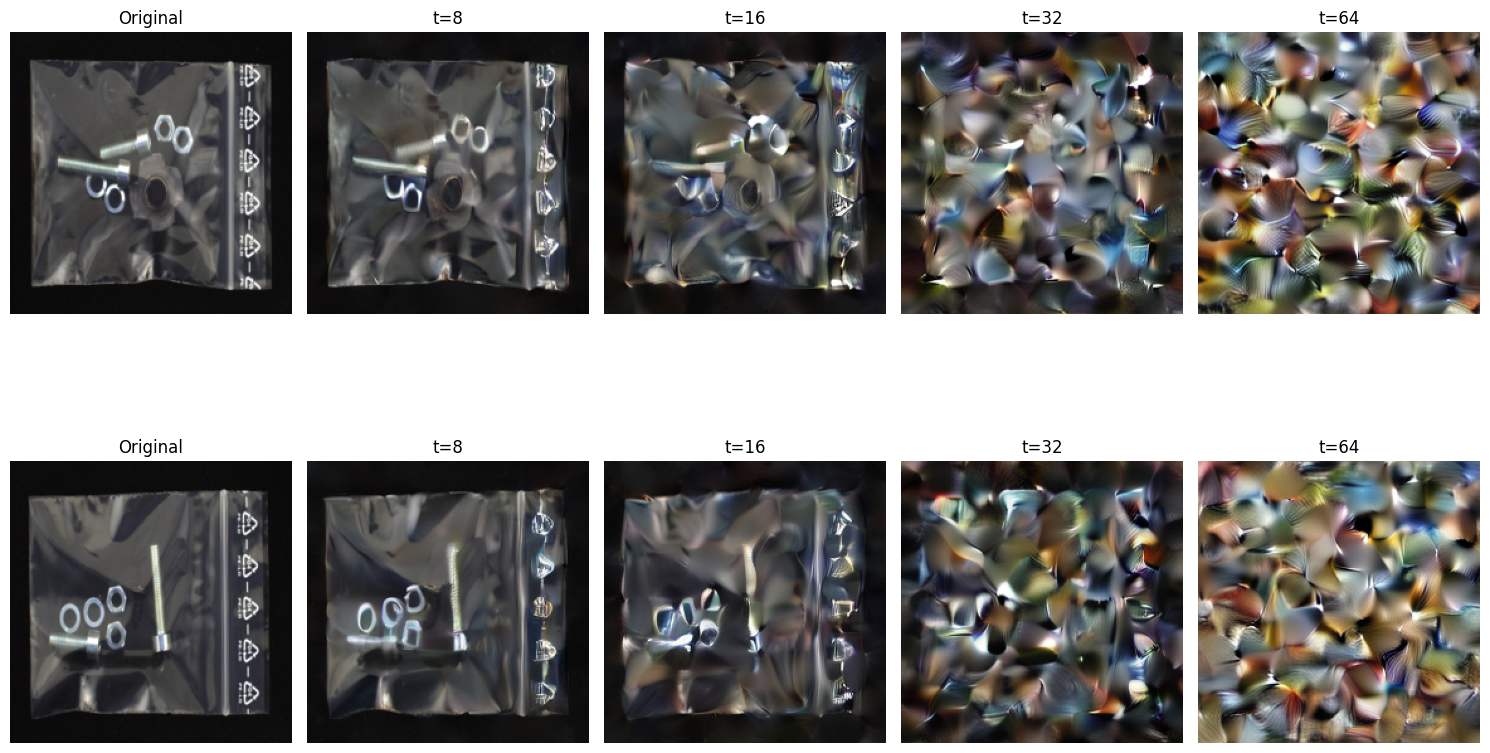

In [63]:
# Visualize the vae reconstruction with perturbed latent

z_t_list = []
for t in t_range:
    z_t = denoiser.q_sample(z, torch.tensor([t] * bs).cuda())
    z_t_list.append(z_t)

recon_t_samples = []
for z_t in z_t_list:
    with torch.no_grad():
        x_t = vae.decode(z_t / 0.2325).cpu()
    recon_t_samples.append(denormalize(x_t.permute(0, 2, 3, 1).numpy()))
    
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(2):
    ax[i, 0].imshow(anomaly_samples[i])
    ax[i, 0].axis("off")
    ax[i, 0].set_title("Original")
    for j in range(4):
        ax[i, j + 1].imshow(recon_t_samples[j][i])
        ax[i, j + 1].axis("off")
        ax[i, j + 1].set_title(f"t={t_range[j]}")
    
plt.tight_layout()
plt.show()

In [25]:
# get latent
with torch.no_grad():
    posterior = vae.encode(samples)
    z = posterior.sample().mul_(0.2325)
print(z.shape)

# add noise
t_idx = -3
t = torch.tensor([t_range[t_idx]] * bs).cuda()
labels = batch["clslabels"].cuda()
noised_latents = denoiser.q_sample(z, t)

# denoising
with torch.no_grad():
    denoised_latents = denoiser.denoise_from_intermediate(z, t, labels)
print(denoised_latents.shape)

torch.Size([4, 16, 14, 14])
torch.Size([4, 16, 14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0403739..1.9502941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0758014..1.878239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1067652..1.8805848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1582396..1.8267968].


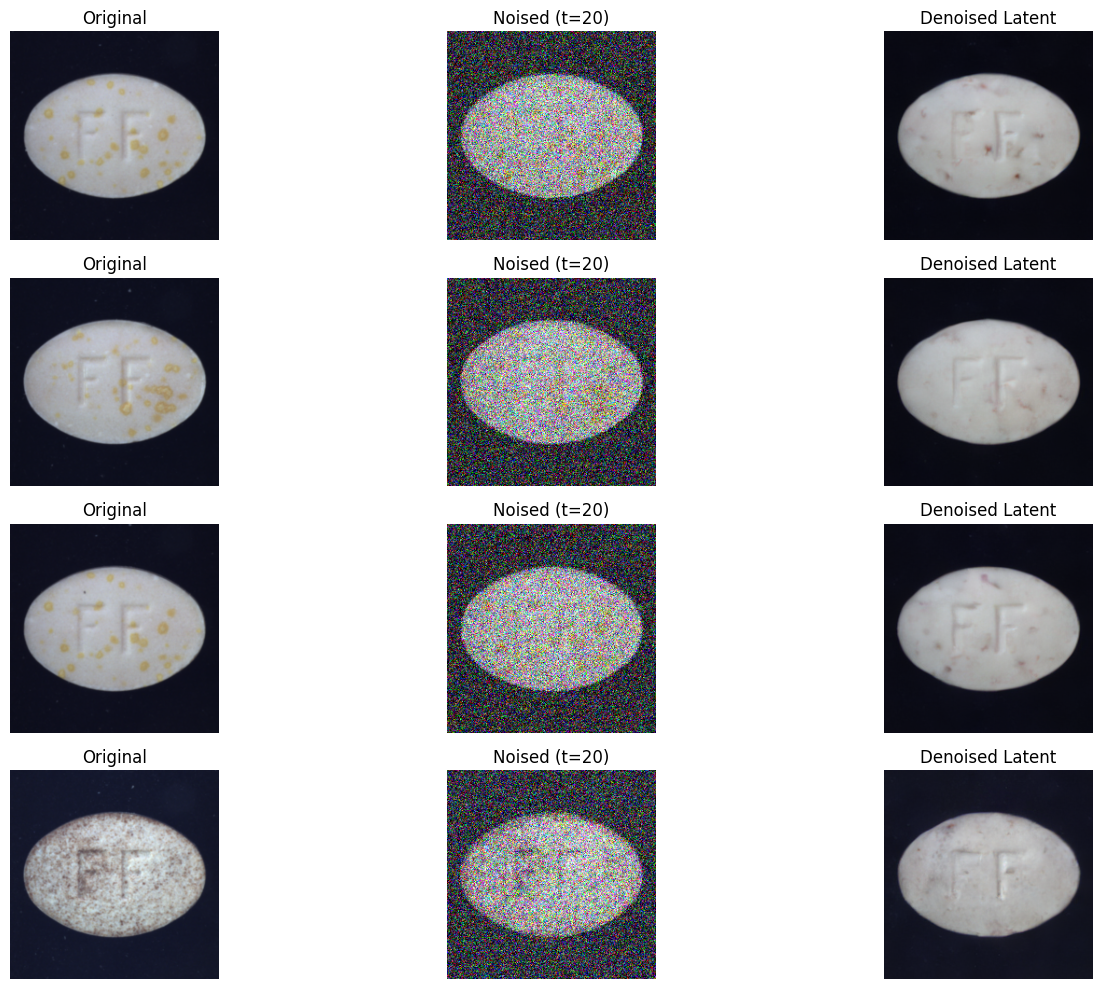

In [26]:
# visualize denoised latents

with torch.no_grad():
    x_reconst = vae.decode(denoised_latents / 0.2325).cpu()
x_reconst = denormalize(x_reconst.permute(0, 2, 3, 1).numpy())  

fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for i in range(4):
    ax[i, 0].imshow(anomaly_samples[i])
    ax[i, 0].axis("off")
    ax[i, 0].set_title("Original")
    
    ax[i, 1].imshow(denormalize(x_t_list[t_idx][i].permute(1, 2, 0).cpu().numpy()))
    ax[i, 1].axis("off")
    ax[i, 1].set_title(f"Noised (t={t_range[t_idx]})")
    
    ax[i, 2].imshow(x_reconst[i])
    ax[i, 2].axis("off")
    ax[i, 2].set_title("Denoised Latent")
    
plt.tight_layout()
plt.show()